In [54]:
import numpy as np

In [55]:
import matplotlib.pyplot as plt

In [56]:
from ccdc.io import MoleculeReader

In [114]:
import ATLK

In [58]:
import math

In [59]:
from ccdc import crystal

In [60]:
from ccdc import io

In [61]:
from ccdc import utilities

In [62]:
def distance(a,b):
    """
    calculate distance between two atoms
    """
    x = a.coordinates.x-b.coordinates.x
    y = a.coordinates.y-b.coordinates.y
    z = a.coordinates.z-b.coordinates.z
    distance = np.linalg.norm((x,y,z))
    return round(distance,10)

In [63]:
def getSegments(crystal,limit,l_left,u_right):
    """
    crystal: crystal to be analyzed
    limit: the linit of the distance between atoms
    l_left: lower ledt coordinate of the packed cells
    u_right: upper right coordinate of the packed cells
    """
    #Pack the molecules together
    packed = crystal.packing(((l_left),(u_right)),
                             'Centroidincluded')
    #Get the atoms of this packed molecule 
    atoms = packed.atoms
    nums = len(atoms)
    segments = np.empty((0,2,3))
    for i in range(nums):
        atom1 = atoms[i]
        for  j in range(i+1,nums):
            atom2 = atoms[j]
            start = np.array(atom1.coordinates[0:3])
            end = np.array(atom2.coordinates[0:3])
            for i in range(3):
                start[i] = round(start[i],6)
                end[i] = round(end[i],6)
            #check if the distacne is less than the limit
            if(distance(atom1,atom2)<=limit):
                segments = np.concatenate((segments,np.array([[start,end]])),axis=0)
    return segments       

In [64]:
def periodicSegments(atoms,atom1,atom2):
    label_1 = atom1.label
    label_2 = atom2.label
    dis = distance(atom1,atom2)
    atoms_1 = []
    atoms_2 = []
    periodic_seg = np.empty((0,2,3))
    for atom in atoms:
        if (atom.label==label_1):
                atoms_1.append(atom)  
        if(atom.label == label_2):
                atoms_2.append(atom)
    for i in range(len(atoms_1)):
        if(distance(atoms_1[i],atoms_2[i])==dis):
            start = np.array(atoms_1[i].coordinates[0:3])
            end = np.array(atoms_2[i].coordinates[0:3])
            periodic_seg= np.concatenate((periodic_seg,np.array([[start,end]])),axis=0)
    return atoms_1,atoms_2,periodic_seg

In [411]:
def periodicSegments_cell(crystal,segment,a,b,c):
    """
    crystal:crystal to be analyzed
    segment: basic segment
    a,b,c: the upper-right coordinate of the packed cells
    """
    segments = np.ones([a*b*c,2,3])
    vectors = getVectors(crystal)
    t = 0
    for i in range(a):
        for j in range(b):
            for k in range(c):
                #The start of the periodic copy in [i,j,k] cell
                segments[t][0] = segment[0]+vectors[0]*i+vectors[1]*j+vectors[2]*k
                #The end of the periodic copy in [i,j,k] cell
                segments[t][1] = segment[1]+vectors[0]*i+vectors[1]*j+vectors[2]*k
                t = t+1
    return segments

In [66]:
def inside_test(points , cube3d):
    """
    cube3d  =  numpy array of the shape (8,3) with coordinates in the clockwise order. first the bottom plane is considered then the top one.
    points = array of points with shape (N, 3).

    Returns the indices of the points array which are outside the cube3d
    """
    b1,b2,b3,b4,t1,t2,t3,t4 = cube3d

    dir1 = (t1-b1)
    size1 = np.linalg.norm(dir1)
    dir1 = dir1 / size1

    dir2 = (b2-b1)
    size2 = np.linalg.norm(dir2)
    dir2 = dir2 / size2

    dir3 = (b4-b1)
    size3 = np.linalg.norm(dir3)
    dir3 = dir3 / size3

    cube3d_center = (b1 + t3)/2.0

    dir_vec = points - cube3d_center

    res1 = np.where( (np.absolute(np.dot(dir_vec, dir1)) * 2) > size1 )[0]
    res2 = np.where( (np.absolute(np.dot(dir_vec, dir2)) * 2) > size2 )[0]
    res3 = np.where( (np.absolute(np.dot(dir_vec, dir3)) * 2) > size3 )[0]

    return list( set().union(res1, res2, res3) )

In [67]:
def getVectors(crystal):
    """
    Parameter
    ---------
    Crystal: the crystal to be analyzed
    --------
    Return
    This function will return vectors between relative atoms in its 3 directions 
    """
    packed_o = crystal.packing(((0,0,0),(1,1,1)),'Centroidincluded')
    #The cell whose lower-left coordinate is (0,0,1)
    packed_z = crystal.packing(((0,0,1),(1,1,2)),'Centroidincluded')
    #The cell whose lower-left coordinate is (0,1,0)
    packed_y = crystal.packing(((0,1,0),(1,2,1)),'Centroidincluded')
    #The cell whose lower-left coordinate is (1,0,0)
    packed_x = crystal.packing(((1,0,0),(2,1,1)),'Centroidincluded')
    #vec_x is the unit vector in axis-x's direction
    vec_x = np.array(packed_x.atoms[0].coordinates)-np.array(packed_o.atoms[0].coordinates)
    #vec_y is the unit vector in axis-y's direction
    vec_y = np.array(packed_y.atoms[0].coordinates)-np.array(packed_o.atoms[0].coordinates)
    #vec_z is the unit vector in axis-z's direction
    vec_z = np.array(packed_z.atoms[0].coordinates)-np.array(packed_o.atoms[0].coordinates)
    for i in range(3):
        vec_x[i]=round(vec_x[i],6)
        vec_y[i]=round(vec_y[i],6)
        vec_z[i]=round(vec_z[i],6)
    return [vec_x,vec_y,vec_z]

In [68]:
def getCoordinates(crystal,lower_left_point,):
    """
    crystal:the crystal to be analyzed
    lower_left_point: the lower-left point of unit cell
    --------
    Return the 8 coordiantes of the unit cell
    """
    vectors = getVectors(crystal)
    lower_left_point=np.dot(lower_left_point[0],vectors[0])+np.dot(lower_left_point[1],vectors[1])+np.dot(lower_left_point[2],vectors[2])
    return(lower_left_point,lower_left_point+vectors[1],
           lower_left_point+vectors[0],lower_left_point+vectors[0]+vectors[1],
           lower_left_point+vectors[2],lower_left_point+vectors[2]+vectors[1],
           lower_left_point+vectors[2]+vectors[0],lower_left_point+vectors[2]+vectors[0]+vectors[1])

In [389]:
#[a1,a2,a3],[b1,b2,b3]
#[c1,c1,c3],[d1,d2,d3]
def check_cop(segment1,segment2):
    """
    segment1 : shape is (1,2,3)
    segment2 : shape (1,2,3)
    Return 1 if they are coplanar or 0 if not coplannar
    """
    a1, a2, a3 = segment1[0][0],segment1[0][1],segment1[0][2]
    b1, b2, b3 = segment1[1][0],segment1[1][1],segment1[1][2]
    c1, c2, c3 = segment2[0][0],segment2[0][1],segment2[0][2]
    d1, d2, d3 = segment2[1][0],segment2[1][1],segment2[1][2]
    if([b1-a1,b2-a2,b3-a3]==[d1-c1,d2-c2,d3-c3]or[b1-a1,b2-a2,b3-a3]==[c1-d1,c2-d2,c3-d3]):
        return 1
    else:
        A=b1-a1
        B=c1-d1
        C=c1-a1
        D=b2-a2
        E=c2-d2
        F=c2-a2
        #find t and s using formula
        t=(C*E-F*B)/(E*A-B*D)
        s=(D*C-A*F)/(D*B-A*E)
        #check if third equation is also satisfied(we have 3 equations and 2 variable
        if ((t*(b3-a3)+s*(c3-d3))==c3-a3):
            return 1
        else:
            return 0

In [72]:
def inside_test(points , cube3d):
    """
    cube3d  =  numpy array of the shape (8,3) with coordinates in the clockwise order. first the bottom plane is considered then the top one.
    points = array of points with shape (N, 3).

    Returns the indices of the points array which are outside the cube3d
    """
    b1,b2,b3,b4,t1,t2,t3,t4 = cube3d

    dir1 = (t1-b1)
    size1 = np.linalg.norm(dir1)
    dir1 = dir1 / size1

    dir2 = (b2-b1)
    size2 = np.linalg.norm(dir2)
    dir2 = dir2 / size2

    dir3 = (b4-b1)
    size3 = np.linalg.norm(dir3)
    dir3 = dir3 / size3

    cube3d_center = (b1 + t3)/2.0

    dir_vec = points - cube3d_center

    res1 = np.where( (np.absolute(np.dot(dir_vec, dir1)) * 2) > size1 )[0]
    res2 = np.where( (np.absolute(np.dot(dir_vec, dir2)) * 2) > size2 )[0]
    res3 = np.where( (np.absolute(np.dot(dir_vec, dir3)) * 2) > size3 )[0]

    return list( set().union(res1, res2, res3) )

In [133]:
def periodic_lk(segment1,segments):
    """
    This function will calculate the periodic linking number between segment1 and segments
    segments: a. umpy array store the periodc copies of one segment
    """
    simplink = 0 
    pln = np.empty((1))
    for segment in segments:
        segp = ATLK.Segquad([segment1,segment])
        #segp is segmente paie
        simplink += segp.segatan()
        #Linking number between segments
        pln = np.concatenate((pln,np.array([simplink])),axis=0)
    pln = pln[1:pln.shape[0]]
    return pln

In [74]:
def lk(segments):
    """
    calculate the linking number between ant two segments in the segments numpy array
    """
    num = segments.shape[0]
    lk = np.empty((num,num))
    for i in range(num):
        for j in range (num):
            if (check_cop(segments[i],segments[j])==0):
                segp = ATLK.Segquad([segments[i],segments[j]]).segatan()
                lk[i][j]=segp
            else:
                lk[i][j]=0
    return lk

In [75]:
def description(crystal):
    csd = io.CrystalReader(crystal)
    crystal_tri = csd[0]
    print(crystal_tri.cell_angles)
    print(crystal_tri.cell_lengths)
    atoms = crystal_tri.molecule.atoms
    print("The molecule of the crystal has",len(atoms),"atoms")
    for atom in atoms[0:5]:
        print(atom.label,atom.coordinates)

In [76]:
description("1100119.cif")

CellAngles(alpha=105.87, beta=97.74, gamma=106.317)
CellLengths(a=7.6996, b=8.838, c=12.197)
The molecule of the crystal has 59 atoms
Al1 Coordinates(x=4.790, y=1.038, z=-0.453)
F1 Coordinates(x=3.459, y=0.719, z=0.844)
F2 Coordinates(x=3.590, y=1.663, z=-1.569)
F3 Coordinates(x=6.039, y=1.084, z=-1.726)
F4 Coordinates(x=5.202, y=2.643, z=0.198)


In [77]:
csd = io.CrystalReader("1100119.cif")
crystal_tri = csd[0]

In [390]:
#crystal is the crystal to be analyzed
#3 is the distance lmit
#(0,0,0) and (1,1,1) means that we select the first unit cell
segments = getSegments(crystal_tri,3,(0,0,0),(1,1,1))

In [391]:
print(segments[0:5])

[[[ 4.789755  1.03801  -0.453147]
  [ 3.458856  0.719299  0.844397]]

 [[ 4.789755  1.03801  -0.453147]
  [ 3.589838  1.662648 -1.569454]]

 [[ 4.789755  1.03801  -0.453147]
  [ 6.039389  1.08358  -1.725908]]

 [[ 4.789755  1.03801  -0.453147]
  [ 5.202017  2.642921  0.197566]]

 [[ 4.789755  1.03801  -0.453147]
  [ 6.007997  0.369964  0.689541]]]


In [392]:
lk_matrix = lk(segments[100:103])
lk_matrix

array([[0.        , 0.        , 0.07441132],
       [0.        , 0.        , 0.0758642 ],
       [0.07441132, 0.0758642 , 0.        ]])

In [393]:
#vectors needs to find the copies of one segment
getVectors(crystal_tri)

[array([7.6996, 0.    , 0.    ]),
 array([-2.483049,  8.482023,  0.      ]),
 array([-1.642667, -3.956196, 11.420025])]

In [442]:
#Find the periodic copies of segments[3] in 3d-space composed by 8 unit cells
periodic_segments = periodicSegments_cell(crystal_tri,segments[0],2,2,2)

In [463]:
periodic_segments

array([[[ 4.789755,  1.03801 , -0.453147],
        [ 3.458856,  0.719299,  0.844397]],

       [[ 3.147088, -2.918186, 10.966878],
        [ 1.816189, -3.236897, 12.264422]],

       [[ 2.306706,  9.520033, -0.453147],
        [ 0.975807,  9.201322,  0.844397]],

       [[ 0.664039,  5.563837, 10.966878],
        [-0.66686 ,  5.245126, 12.264422]],

       [[12.489355,  1.03801 , -0.453147],
        [11.158456,  0.719299,  0.844397]],

       [[10.846688, -2.918186, 10.966878],
        [ 9.515789, -3.236897, 12.264422]],

       [[10.006306,  9.520033, -0.453147],
        [ 8.675407,  9.201322,  0.844397]],

       [[ 8.363639,  5.563837, 10.966878],
        [ 7.03274 ,  5.245126, 12.264422]]])

In [445]:
for segment in periodic_segments:
    print(segment[1]-segment[0])

[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]


In [465]:
for i in range(8):
    for j in range(8):
        print(periodic_segments[i]-periodic_segments[j])

[[0. 0. 0.]
 [0. 0. 0.]]
[[  1.642667   3.956196 -11.420025]
 [  1.642667   3.956196 -11.420025]]
[[ 2.483049 -8.482023  0.      ]
 [ 2.483049 -8.482023  0.      ]]
[[  4.125716  -4.525827 -11.420025]
 [  4.125716  -4.525827 -11.420025]]
[[-7.6996  0.      0.    ]
 [-7.6996  0.      0.    ]]
[[ -6.056933   3.956196 -11.420025]
 [ -6.056933   3.956196 -11.420025]]
[[-5.216551 -8.482023  0.      ]
 [-5.216551 -8.482023  0.      ]]
[[ -3.573884  -4.525827 -11.420025]
 [ -3.573884  -4.525827 -11.420025]]
[[-1.642667 -3.956196 11.420025]
 [-1.642667 -3.956196 11.420025]]
[[0. 0. 0.]
 [0. 0. 0.]]
[[  0.840382 -12.438219  11.420025]
 [  0.840382 -12.438219  11.420025]]
[[ 2.483049 -8.482023  0.      ]
 [ 2.483049 -8.482023  0.      ]]
[[-9.342267 -3.956196 11.420025]
 [-9.342267 -3.956196 11.420025]]
[[-7.6996  0.      0.    ]
 [-7.6996  0.      0.    ]]
[[ -6.859218 -12.438219  11.420025]
 [ -6.859218 -12.438219  11.420025]]
[[-5.216551 -8.482023  0.      ]
 [-5.216551 -8.482023  0.      ]]


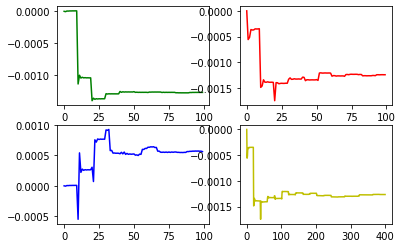

In [397]:
ax1 = plt.subplot(2,2,1)
#plot the curve at position 1
periodic_segments = periodicSegments_cell(crystal_tri,segments[6],10,1,10)
#Get the periodic segments of segments[6] in space (10,1,10)
pln = periodic_lk(segments[1],periodic_segments)
#Calculate the pln between segments[1] and segments[6] and store the
#result in pln
plt.plot(pln,'g')
#plot the curve in green
ax2 = plt.subplot(2,2,2)
periodic_segments = periodicSegments_cell(crystal_tri,segments[6],10,10,1)
#Get the periodic segments of segments[6] in space (10,1,10)
pln = periodic_lk(segments[1],periodic_segments)
plt.plot(pln,'r')
ax3 = plt.subplot(2,2,3)
periodic_segments = periodicSegments_cell(crystal_tri,segments[6],1,10,10)
#Get the periodic segments of segments[6] in space (1,10,10)
pln = periodic_lk(segments[1],periodic_segments)
plt.plot(pln,'b')
ax4 = plt.subplot(2,2,4)
periodic_segments = periodicSegments_cell(crystal_tri,segments[6],20,20,1)
#Get the periodic segments of segments[6] in space (20,20,1)
pln = periodic_lk(segments[1],periodic_segments)
plt.plot(pln,'y')

In [474]:
periodic_segments = \
periodicSegments_cell(\
    crystal_tri,segments[1],2,2,2)

In [475]:
periodic_segments

array([[[ 4.789755,  1.03801 , -0.453147],
        [ 3.589838,  1.662648, -1.569454]],

       [[ 3.147088, -2.918186, 10.966878],
        [ 1.947171, -2.293548,  9.850571]],

       [[ 2.306706,  9.520033, -0.453147],
        [ 1.106789, 10.144671, -1.569454]],

       [[ 0.664039,  5.563837, 10.966878],
        [-0.535878,  6.188475,  9.850571]],

       [[12.489355,  1.03801 , -0.453147],
        [11.289438,  1.662648, -1.569454]],

       [[10.846688, -2.918186, 10.966878],
        [ 9.646771, -2.293548,  9.850571]],

       [[10.006306,  9.520033, -0.453147],
        [ 8.806389, 10.144671, -1.569454]],

       [[ 8.363639,  5.563837, 10.966878],
        [ 7.163722,  6.188475,  9.850571]]])

In [467]:
for segment in periodic_segments:
    print(segment[1]-segment[0])

[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]
[-1.330899 -0.318711  1.297544]


In [237]:
periodic_segments_1 = periodic_segments.reshape(,3)

ValueError: cannot reshape array of size 600 into shape (800,3)

In [238]:
periodic_segments_1

array([[   4.789755,    1.03801 ,   -0.453147],
       [   5.202017,    2.642921,    0.197566],
       [   4.789755,    9.520033,   -4.409343],
       ...,
       [ 151.494417,  108.141404, -102.224635],
       [ 151.082155,  115.018516, -106.831544],
       [ 151.494417,  116.623427, -106.180831]])

In [209]:
lk(segments[100:103])

array([[0.        , 0.        , 0.07441132],
       [0.        , 0.        , 0.0758642 ],
       [0.07441132, 0.0758642 , 0.        ]])

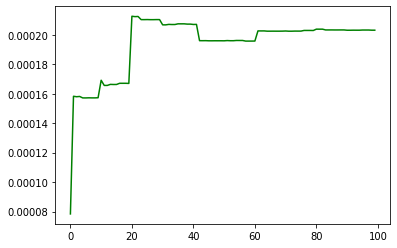

In [136]:
plt.plot(pln,'g')

In [409]:
segments[1]

array([[ 4.789755,  1.03801 , -0.453147],
       [ 3.589838,  1.662648, -1.569454]])

In [191]:
segp_1 = ATLK.Segquad([[[1,0,0],[1,1,0]],[[1,0,1],[0,0,1]]])
segp_2 = ATLK.Segquad([[[0,0,0],[1,1,0]],[[0,0,1],[1,1,1]]])
segp_3 = ATLK.Segquad([[[0,0,0],[1,0.5,0]],[[0,0,1],[1,0,1]]])

In [177]:
print(segp_1.lonevec,segp_1.ltwovec,segp_1.startdist,segp_1.cross)
print(segp_2.lonevec,segp_2.ltwovec,segp_2.startdist,segp_2.cross)
print(segp_3.lonevec,segp_3.ltwovec,segp_3.startdist,segp_3.cross)

[0. 1. 0.] [-1.  0.  0.] [0. 0. 1.] [ 0. -0.  1.]
[1. 1. 0.] [1. 1. 0.] [0. 0. 1.] [0. 0. 0.]
[1.  0.5 0. ] [1. 0. 0.] [0. 0. 1.] [ 0.   0.  -0.5]


In [192]:
print(segp_1.segdist(),segp_2.segdist(),segp_3.segdist())

1.0 nan -1.0


In [195]:
print(segp_1.angle,segp_2.angle,segp_3.angle)

1.5707963267948966 2.1073424255447017e-08 0.46364760900080615


In [407]:
print(segp_1.segatan(),segp_2.segatan(),segp_3.segatan())

-0.021974467386391593 nan 0.09450903628525198


/Users/user/ATLK.py:78: RuntimeWarning: invalid value encountered in double_scalars
  return trp(self.lonevec,self.ltwovec,self.startdist)/np.linalg.norm(self.cross)


In [415]:
points = periodicSegments_cell(crystal_tri,segments[3],2,2,2)

In [418]:
points = points.reshape(16,3)

In [423]:
inside_test(points,getCoordinates(crystal_tri,[1,1,0]))

[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

In [428]:
inside_test(points,getCoordinates(crystal_tri,[0,0,0]))

[0, 1, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15]

In [430]:
points

array([[ 4.789755,  1.03801 , -0.453147],
       [ 5.202017,  2.642921,  0.197566],
       [ 3.147088, -2.918186, 10.966878],
       [ 3.55935 , -1.313275, 11.617591],
       [ 2.306706,  9.520033, -0.453147],
       [ 2.718968, 11.124944,  0.197566],
       [ 0.664039,  5.563837, 10.966878],
       [ 1.076301,  7.168748, 11.617591],
       [12.489355,  1.03801 , -0.453147],
       [12.901617,  2.642921,  0.197566],
       [10.846688, -2.918186, 10.966878],
       [11.25895 , -1.313275, 11.617591],
       [10.006306,  9.520033, -0.453147],
       [10.418568, 11.124944,  0.197566],
       [ 8.363639,  5.563837, 10.966878],
       [ 8.775901,  7.168748, 11.617591]])

array([[ 8.363639,  5.563837, 10.966878],
       [ 8.775901,  7.168748, 11.617591]])

In [73]:
t = np.empty(0)

In [162]:
 segments = np.empty((0,3))

In [165]:
segments = np.concatenate((segments,np.array([[1,1,1]])),axis=0)

In [167]:
segments[0]

array([1., 1., 1.])

In [158]:
segments.shape

(2, 3)

In [12]:
print(packed.atoms)

[Atom(O8), Atom(O7), Atom(O3), Atom(O5), Atom(O6), Atom(O4), Atom(O1), Atom(O2), Atom(C8), Atom(H8A), Atom(H8B), Atom(C5), Atom(C3), Atom(C13), Atom(C1), Atom(C9), Atom(H9A), Atom(H9B), Atom(C2), Atom(H2A), Atom(H2B), Atom(C14), Atom(C10), Atom(C4), Atom(H4A), Atom(H4B), Atom(C6), Atom(H6A), Atom(H6B), Atom(C7), Atom(H7A), Atom(H7B), Atom(C12), Atom(C11), Atom(H5), Atom(H7), Atom(H2), Atom(H4), Atom(O8), Atom(O7), Atom(O3), Atom(O5), Atom(O6), Atom(O4), Atom(O1), Atom(O2), Atom(C8), Atom(H8A), Atom(H8B), Atom(C5), Atom(C3), Atom(C13), Atom(C1), Atom(C9), Atom(H9A), Atom(H9B), Atom(C2), Atom(H2A), Atom(H2B), Atom(C14), Atom(C10), Atom(C4), Atom(H4A), Atom(H4B), Atom(C6), Atom(H6A), Atom(H6B), Atom(C7), Atom(H7A), Atom(H7B), Atom(C12), Atom(C11), Atom(H5), Atom(H7), Atom(H2), Atom(H4)]


In [698]:
segp = ATLK.Segquad([segment_s[0],segment_s[0]])

array([[ 9.87426565, 11.80381977, 11.3396011 ],
       [10.5334138 , 12.91087377,  9.50887032]])

In [264]:
segment_s[1]

array([[ 9.87426565, 11.80381977, 11.3396011 ],
       [10.12864206,  9.31877055, 10.18055635]])

In [699]:
segp.segatan()

/Users/user/ATLK.py:86: RuntimeWarning: invalid value encountered in true_divide
  b = self.startdist/((np.sin(self.angle))**2)
/Users/user/ATLK.py:81: RuntimeWarning: invalid value encountered in double_scalars
  return trp(self.lonevec,self.ltwovec,self.startdist)/np.linalg.norm(self.cross)


0.0

In [301]:
crystal_tri = io.CrystalReader('1100119.cif')[0]

In [343]:
packed_tri_1 = crystal_tri.packing(((0,0,0),(1.0,1.0,1.0)),'Centroidincluded')

In [344]:
packed_tri_1.centre_of_geometry()

Coordinates(x=1.787, y=2.263, z=5.710)

In [304]:
crystal_tri.cell_lengths

CellLengths(a=7.6996, b=8.838, c=12.197)

In [307]:
packed_tri_1_5 = crystal_tri.packing(((0,0,0),(1.5,1.5,1.5)),'Centroidincluded')

In [308]:
packed_tri_1_5.centre_of_geometry()

Coordinates(x=2.303, y=3.308, z=8.324)

In [76]:
round([1.111111],4)

TypeError: type list doesn't define __round__ method

[0. 0. 0.] [ 7.699 -0.    -0.   ] [-2.483  8.482 -0.   ] [-1.643 -3.956 11.42 ] [ 7.699 -0.    -0.   ] [ 5.216  8.482 -0.   ] [ 6.056 -3.956 11.42 ] [-4.126  4.526 11.42 ] [ 3.573  4.526 11.42 ]


In [517]:
getCoordinates(crystal_tri,np.array([1,1,1]))

(array([ 3.57388341,  4.52582708, 11.42002487]),
 array([ 1.09083426, 13.00784989, 11.42002487]),
 array([11.27348341,  4.52582708, 11.42002487]),
 array([ 8.79043426, 13.00784989, 11.42002487]),
 array([ 1.93121597,  0.56963136, 22.84004974]),
 array([-0.55183317,  9.05165416, 22.84004974]),
 array([ 9.63081597,  0.56963136, 22.84004974]),
 array([ 7.14776683,  9.05165416, 22.84004974]))

In [450]:
vectors = getVectors(crystal_tri)

In [520]:
packed = crystal_tri.packing(((0,0,0),(1,1,1)),'Centroidincluded')

In [555]:
segments = getSegments(packed.atoms,0.9)

In [375]:
segments

array([[[ 4.789755,  1.03801 , -0.453147],
        [ 3.589838,  1.662648, -1.569454]],

       [[ 4.789755,  1.03801 , 10.966878],
        [ 3.589838,  1.662648,  9.850571]],

       [[ 4.789755,  9.520033, -4.409343],
        [ 3.589838, 10.144671, -5.52565 ]],

       [[ 4.789755,  9.520033,  7.010682],
        [ 3.589838, 10.144671,  5.894375]],

       [[12.489355, -1.445039, -2.095814],
        [11.289438, -0.820401, -3.212121]],

       [[12.489355, -1.445039,  9.324211],
        [11.289438, -0.820401,  8.207904]],

       [[12.489355,  7.036984, -6.05201 ],
        [11.289438,  7.661622, -7.168317]],

       [[12.489355,  7.036984,  5.368015],
        [11.289438,  7.661622,  4.251708]]])

In [560]:
points = segments.reshape(segments.shape[0]*segments.shape[1],segments.shape[2])

In [562]:
inside_test(points,np.array(getCoordinates(crystal_tri,np.array([0.5,0.5,0.5]))))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 36]

In [59]:
np.array([1,2,3])/np.array([1,0,3])

/Users/user/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 1., inf,  1.])

In [310]:
for i in range(5):
    print(i)

0
1
2
3
4


In [330]:
np.dot(vectors,[4,4,4])

array([8, 8, 8])

In [359]:
vectors = getVectors(crystal_tri)

In [328]:
vectors=[np.array([2,0,0]),np.array([0,2,0]),np.array([0,0,2])]

In [342]:
getVectors(crystal_tri)

[array([7.6996, 0.    , 0.    ]),
 array([-2.483049,  8.482023,  0.      ]),
 array([-1.642667, -3.956196, 11.420025])]

array([[ 4.789755,  1.03801 , -0.453147],
       [ 3.589838,  1.662648, -1.569454]])

[0, 0, 0]
[0. 0. 0.]
[0, 0, 1]
[ 0.        0.       11.420025]
[0, 1, 0]
[ 0.        8.482023 -3.956196]
[0, 1, 1]
[0.       8.482023 7.463829]
[1, 0, 0]
[ 7.6996   -2.483049 -1.642667]
[1, 0, 1]
[ 7.6996   -2.483049  9.777358]
[1, 1, 0]
[ 7.6996    5.998974 -5.598863]
[1, 1, 1]
[7.6996   5.998974 5.821162]


array([ 3.573884,  4.525827, 11.420025])

array([ 0.      ,  0.      , 11.420025])

ValueError: shapes (2,3) and (2,3) not aligned: 3 (dim 1) != 2 (dim 0)